In [1]:
from statsmodels.graphics import boxplots
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import json

PLAYTIME_THRESHOLD = 10

In [2]:
def convert_game(game: object) -> pd.Series:
    game = pd.json_normalize(game)
    game["playtime_forever"] = game["playtime_forever"].apply(lambda p: p / 60)
    game = game.where(lambda p: p["playtime_forever"] > PLAYTIME_THRESHOLD).dropna()
    return game

games = pd.read_json("games.json")
games["games"] = games["games"].apply(convert_game)

In [3]:
def convert_game_info(gi):
    gi["appid"] = gi["game_info"]["steam_appid"]
    gi["name"] = gi["game_info"]["name"]
    if gi["game_info"]["genres"] is None:
        gi["game_info"]["genres"] = []
    gi["genres"] = list(map(lambda g: g["description"], gi["game_info"]["genres"]))
    if len(gi["reviews"]) > 0:
        gi["reviews"] = round(float(gi["reviews"][0]["weighted_vote_score"]), ndigits=2)
    else:
        return None
    return gi

game_info = pd.read_json("game_info.json")
game_info = game_info.apply(convert_game_info, axis=1)

In [4]:
def convert_to_percentage(game_time):
    return game_time

for i in range(len(games["games"])):
    games["games"][i]["playtime_forever"] = convert_to_percentage(games["games"][i]["playtime_forever"])

In [5]:
all_genres = set()
for app_genre_list in game_info['genres']:
    if app_genre_list is not None:
        for genre in app_genre_list:
            all_genres.add(genre)

In [6]:
# Given the appid of a game, we will get its associated genre
def genre_from_appid(appid):
    indices = game_info[game_info["appid"]==appid].index.values
    if len(indices) == 0:
        return []
    return game_info["genres"][indices[0]]


In [7]:
# want to create a dictionary then have it be a column in games df
genre_dict = {}
for genre in list(all_genres):
    genre_dict[genre] = 0

player_list = []
for player in games["player"]:
    player_list.append(genre_dict.copy())

games["genre_mapping"] = player_list


In [8]:
def getplaytime(appid, player):
    player_rec = games["games"][player]
    indices = player_rec.index[abs(player_rec["appid"] - appid) < 1e-6]
    if len(indices) == 0:
        return 0
    return player_rec["playtime_forever"][indices.values[0]]
    

In [9]:
for player, players_game in enumerate(games["games"]):
    for i, appid in enumerate(players_game["appid"]):
        for genre in genre_from_appid(appid):
            # get players playtime forever for that appid
            games["genre_mapping"][player][genre] += getplaytime(appid, player)
    

In [10]:
favorite_genre = []
favorite_genre_playtime = []
total_playtime = []
for genre_dict in games["genre_mapping"]:
    total_time = sum(genre_dict.values())
    max_key = max(genre_dict, key=genre_dict.get)
    favorite_genre_playtime.append(genre_dict[max_key])
    favorite_genre.append(max_key)
    total_playtime.append(total_time)

In [11]:
games["favorite_genre"] = favorite_genre
games["favorite_genre_playtime"] = favorite_genre_playtime
games["total_playtime"] = total_playtime

In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
games["favorite_genre"] = le.fit_transform(games["favorite_genre"])
games["player"] = le.fit_transform(games["player"])

In [13]:
clustering_feature = games.iloc[:,3:4]

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(clustering_feature)
clusters = kmeans.fit_predict(clustering_feature)

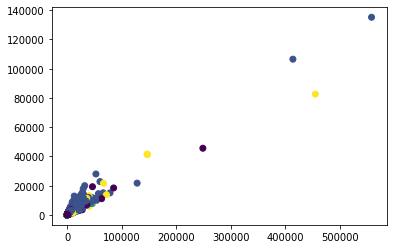

In [15]:
plt.scatter(games["total_playtime"], games["favorite_genre_playtime"], c=clusters)
plt.show()

In the next section we will explore our review and popularity features. 
Questions to explore include, are the most played games, also the ones with the best reviews?

Here, I extracted two useful columns for our analysis to not deal with nested dictionaries

In [16]:
review_df = pd.DataFrame()
review_scores = []
total_reviews = []
for review in game_info['review_summary']:
    if review is None:
        review_scores.append(0)
        total_reviews.append(0)
    else:
        review_scores.append(review['review_score'])
        total_reviews.append(review['total_reviews'])
game_info['review_score'] = review_scores
game_info['total_reviews'] = total_reviews

In [17]:
total_playtime = {}
for game in game_info['appid']:
    total_playtime[game] = 0
for i, game in enumerate(games['games']):
    for _, row in game.iterrows():
        appid = row["appid"]
        playtime = row["playtime_forever"]
        if appid in total_playtime:
            total_playtime[appid] += playtime

total_playtime_tuples = list(reversed(sorted(
    [(k, v) for k, v in total_playtime.items()], 
    key=lambda t: t[1]
    )))


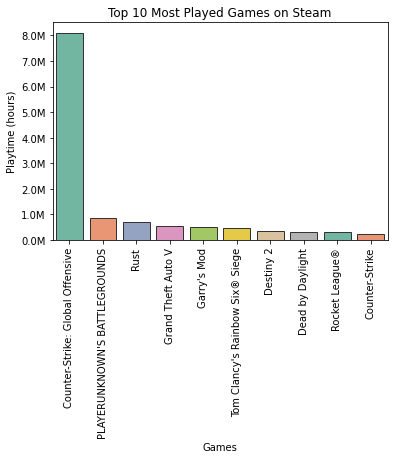

In [18]:
#validation below
import matplotlib.ticker as tc

def get_game_name(appid):
    return game_info["name"][game_info.index[game_info["appid"] == appid].tolist()].iloc[0]

def million_label(value):
    value = value / 1000000
    return str(value) + "M"

# Blue palette for playtime
formatter = tc.FuncFormatter(lambda x, p: million_label(x))
plt.gca().yaxis.set_major_formatter(formatter)

sb.set_style("whitegrid")
sb.barplot(list(map(lambda x: get_game_name(x[0]), total_playtime_tuples[:10])), list(map(lambda x: x[1], total_playtime_tuples[:10])), palette="Set2", linewidth = 1.0, edgecolor = ".2")
plt.xticks(rotation=90)

plt.title("Top 10 Most Played Games on Steam")
plt.xlabel("Games")
plt.ylabel("Playtime (hours)")
plt.show()

In [19]:
# Stolen from Reddit's algorithm (https://gist.github.com/amix/8d14ff0a920d5c15738a#file-sorts-py)

# Rewritten code from /r2/r2/lib/db/_sorts.pyx
from math import sqrt

def _confidence(ups, downs):
    n = ups + downs

    if n == 0:
        return 0

    z = 1.281551565545
    p = float(ups) / n

    left = p + 1/(2*n)*z*z
    right = z*sqrt(p*(1-p)/n + z*z/(4*n*n))
    under = 1+1/n*z*z

    return (left + right) / under, (left - right) / under

def confidence(ups, downs):
    if ups + downs == 0:
        return (0, 0)
    else:
        return _confidence(ups, downs)

In [22]:
with open("review_info.json") as f:
    review_info = json.loads(f.read())["reviews"]

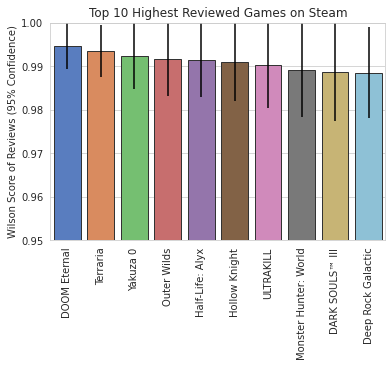

In [23]:
review_scores = {}
for game in review_info:
    for appid, reviews in game.items():
        n_up = len(list(filter(lambda x: x["voted_up"], reviews)))
        n_down = len(list(filter(lambda x: not x["voted_up"], reviews)))
        score = confidence(n_up, n_down)
        review_scores[appid] = score

review_score_tuples = list(reversed(sorted(
    [(k, v) for k, v in review_scores.items()], 
    key=lambda t: t[1][1]
    )))

names = list(map(lambda x: get_game_name(float(x[0])), review_score_tuples[:10]))
scores_low = list(map(lambda x: x[1][1], review_score_tuples[:10]))
scores_hi = list(map(lambda x: x[1][0], review_score_tuples[:10]))
errs = []
for i in range(10):
    errs.append(scores_hi[i] - scores_low[i])

sb.barplot(names, scores_low, yerr=errs, palette="muted", linewidth = 1.0, edgecolor = ".2")
plt.xticks(rotation=90)
plt.ylim(bottom=0.95, top=1.0)
plt.title("Top 10 Highest Reviewed Games on Steam")
plt.ylabel("Wilson Score of Reviews (95% Confidence)")
plt.show()

Do more niche games do better than popular games?

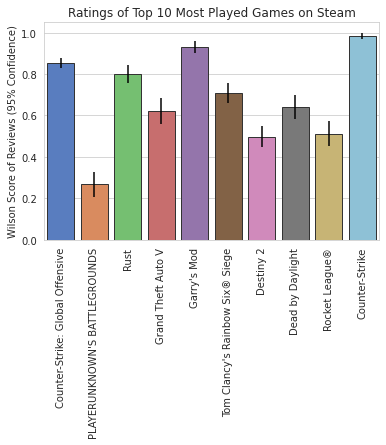

In [24]:
top_playtime_scores = {}
for appid, _ in total_playtime_tuples[:10]:
    score_hi, score_lo = review_scores[str(round(appid))]
    top_playtime_scores[appid] = (score_hi, score_lo)

names = list(map(lambda x: get_game_name(x[0]), top_playtime_scores.items()))
scores_hi = list(map(lambda x: x[1][0], top_playtime_scores.items()))
scores_lo = list(map(lambda x: x[1][1], top_playtime_scores.items()))
errs = []
for i in range(10):
    errs.append(scores_hi[i] - scores_lo[i])

# sb.set_style("whitegrid")
sb.barplot(names, scores_lo, yerr=errs, palette="muted", linewidth = 1.0, edgecolor = ".2")
plt.xticks(rotation=90)
plt.title("Ratings of Top 10 Most Played Games on Steam")
plt.ylabel("Wilson Score of Reviews (95% Confidence)")
plt.show()

In [25]:
def get_game_genres(appid):
    matching_indices = game_info.index[game_info["appid"] == appid]
    if len(matching_indices) == 0:
        return []
    return game_info["genres"][game_info.index[game_info["appid"] == appid].tolist()].iloc[0]

In [26]:
import math
top_genre_games = {"Action" : [], "Massively Multiplayer": [] , "Indie": [], "Simulation": [], "Adventure": []}
for genre in list(top_genre_games.keys()):
    for app in total_playtime_tuples:
        if not math.isnan(app[0]):
            app_genres = get_game_genres(app[0])
            if genre in app_genres:
                if len(top_genre_games[genre]) < 10:
                    top_genre_games[genre].append(app)

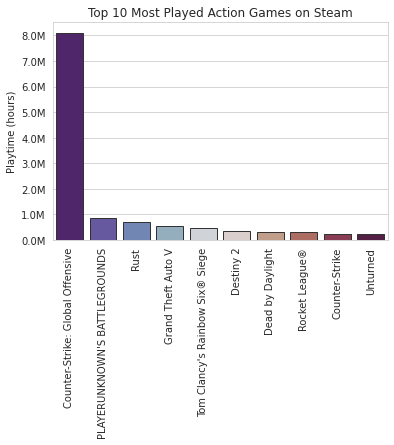

In [27]:
plt.gca().yaxis.set_major_formatter(formatter)
sb.barplot(list(map(lambda x: get_game_name(x[0]), top_genre_games["Action"])), list(map(lambda x: x[1], top_genre_games["Action"])), palette="twilight_shifted",
 linewidth = 1.0, edgecolor = ".2")
plt.xticks(rotation=90)
plt.title("Top 10 Most Played Action Games on Steam")
plt.ylabel("Playtime (hours)")
plt.show()

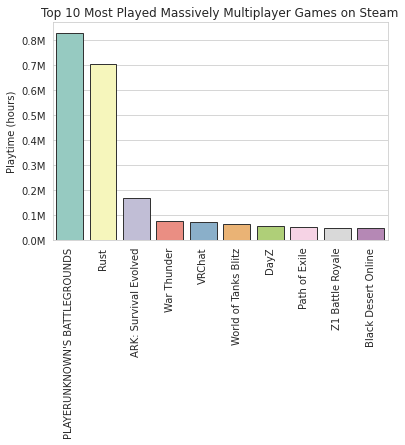

In [28]:
plt.gca().yaxis.set_major_formatter(formatter)
sb.barplot(list(map(lambda x: get_game_name(x[0]), top_genre_games["Massively Multiplayer"])), list(map(lambda x: x[1], top_genre_games["Massively Multiplayer"])), palette="Set3", linewidth = 1.0, edgecolor = ".2")
plt.xticks(rotation=90)
plt.title("Top 10 Most Played Massively Multiplayer Games on Steam")
plt.ylabel("Playtime (hours)")
plt.show()

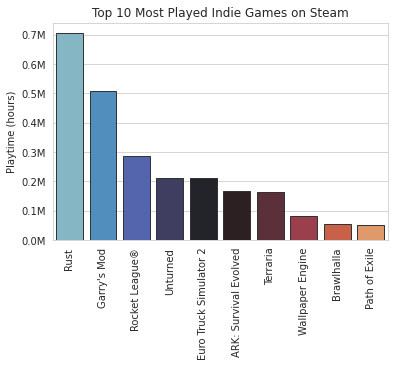

In [29]:
plt.gca().yaxis.set_major_formatter(formatter)
sb.barplot(list(map(lambda x: get_game_name(x[0]), top_genre_games["Indie"])), list(map(lambda x: x[1], top_genre_games["Indie"])), palette="icefire", linewidth = 1.0, edgecolor = ".2")
plt.xticks(rotation=90)
plt.title("Top 10 Most Played Indie Games on Steam")
plt.ylabel("Playtime (hours)")
plt.show()

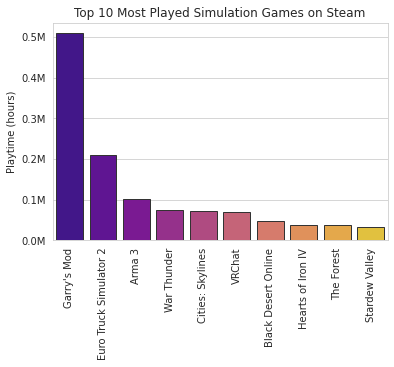

In [30]:
plt.gca().yaxis.set_major_formatter(formatter)
sb.barplot(list(map(lambda x: get_game_name(x[0]), top_genre_games["Simulation"])), list(map(lambda x: x[1], top_genre_games["Simulation"])), palette="plasma", linewidth = 1.0, edgecolor = ".2")
plt.xticks(rotation=90)
plt.title("Top 10 Most Played Simulation Games on Steam")
plt.ylabel("Playtime (hours)")
plt.show()

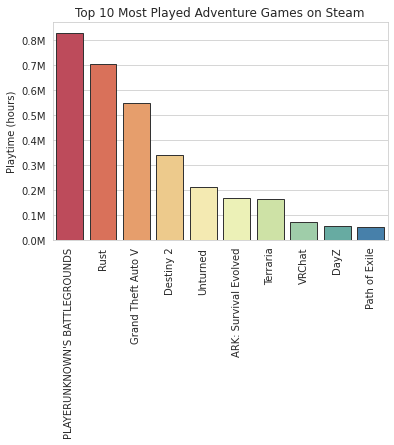

In [31]:
plt.gca().yaxis.set_major_formatter(formatter)
sb.barplot(list(map(lambda x: get_game_name(x[0]), top_genre_games["Adventure"])), list(map(lambda x: x[1], top_genre_games["Adventure"])), palette="Spectral", linewidth = 1.0, edgecolor = ".2")
plt.xticks(rotation=90)
plt.title("Top 10 Most Played Adventure Games on Steam")
plt.ylabel("Playtime (hours)")
plt.show()

In [32]:
playtimes_by_genre = {}
for genre in all_genres:
    playtimes_by_genre[genre] = []

for player in games.iterrows():
    playtimes = player[1]["games"]
    for game in playtimes.iterrows():
        for genre in get_game_genres(game[1]["appid"]):
            playtimes_by_genre[genre].append(game[1]["playtime_forever"])

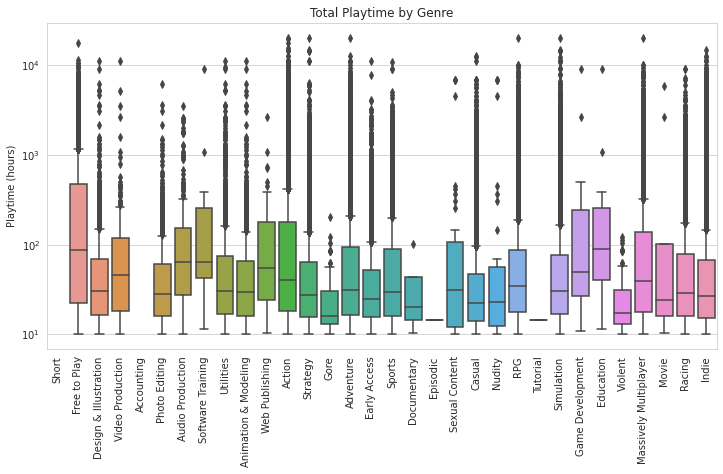

In [33]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_yscale("log")
playtimes_by_genre_df = pd.DataFrame.from_dict(playtimes_by_genre, orient="index").transpose()
sb.boxplot(data=playtimes_by_genre_df)
fig.show()
plt.xticks(rotation=90)
plt.title("Total Playtime by Genre")
plt.ylabel("Playtime (hours)")
plt.show()